# Imports

In [1]:
import os
import pickle
import transformers
import torch
from transformers import AutoTokenizer, AutoModel
import torch.nn.functional as F
import seaborn as sns
import matplotlib.pyplot as plt

# Environment Setup

In [2]:
# There are important!
torch.backends.cuda.enable_mem_efficient_sdp(False)
torch.backends.cuda.enable_flash_sdp(False)

In [ ]:

model_id = "/media/ANONYMOUS/4TB_1/LLM_models/meta-llama/Llama-3.2-1B"

In [4]:
#  Just for Testing 
# pipeline = transformers.pipeline(
#     "text-generation", model=model_id, model_kwargs={"torch_dtype": torch.bfloat16}, device_map="cuda"
# )

# pipeline("Hey how are you doing today?")

# Environment Testing

In [5]:
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModel.from_pretrained(model_id, torch_dtype=torch.bfloat16, device_map="cuda")

In [6]:
# input text
text = "Hey how are you doing today?"

# tokenize and move to CUDA
inputs = tokenizer(text, return_tensors="pt").to("cuda")

print(inputs)

{'input_ids': tensor([[128000,  19182,   1268,    527,    499,   3815,   3432,     30]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}


In [7]:
inputs['input_ids'].size()

torch.Size([1, 8])

In [8]:

# text embedding
with torch.no_grad():
    embeddings = model(**inputs).last_hidden_state

print(embeddings)

tensor([[[ 1.5703, -1.5234,  2.7969,  ..., -0.6680,  0.6211, -1.0469],
         [ 1.7188,  3.0781,  3.7188,  ..., -4.9062, -5.1875,  0.4785],
         [ 2.9062,  1.3906,  1.6406,  ..., -0.4121, -6.4375, -0.4688],
         ...,
         [ 1.7266,  4.5000,  3.3750,  ..., -4.8750, -4.0625, -2.6875],
         [ 1.1641,  4.3125,  3.8438,  ..., -4.0312, -3.7812, -1.2812],
         [ 1.3984,  3.3750,  2.0781,  ..., -5.8125, -5.7188, -0.9688]]],
       device='cuda:0', dtype=torch.bfloat16)


In [9]:
embeddings.size()

torch.Size([1, 8, 2048])

In [10]:
embeddings = embeddings.mean(dim=1).squeeze()
embeddings

tensor([ 1.6172,  2.9062,  2.5625,  ..., -3.6719, -4.0938, -1.5312],
       device='cuda:0', dtype=torch.bfloat16)

In [11]:
embeddings.size()

torch.Size([2048])

# Get Dataset

In [12]:
project_base_path = os.path.dirname(os.path.dirname(os.getcwd()))
project_base_path

'/media/ANONYMOUS/4TB_1/Projects/FALCON'

In [ ]:
gpt4o_generated_cti_path = os.path.join(project_base_path, "data/generation/snort/snort3-community-rules_v1.pkl")
gpt4o_generated_cti_path

'/media/ANONYMOUS/4TB_1/Projects/FALCON/data/generation/snort/snort3-community-rules_gpt.pkl'

In [14]:
def load_from_pickle(file_path):
    """
    Loads data from a pickle file.

    :param file_path: Path to the pickle file
    :return: Loaded data
    """
    try:
        with open(file_path, 'rb') as file:
            return pickle.load(file)
    except Exception as e:
        print(f"Error loading data from pickle: {e}")
        return None

In [15]:
# Load the data back from the pickle file
file_path = gpt4o_generated_cti_path

gpt_snort_cti_dict = load_from_pickle(file_path)
size = len(gpt_snort_cti_dict.keys()) 
print(size)

4017


In [16]:
def get_first_n_elements(dictionary: dict, n: int) -> dict:
    """
    Get the first n elements of a dictionary.

    :param dictionary: The input dictionary
    :param n: The number of elements to retrieve
    :return: A dictionary with the first n elements
    """
    return dict(list(dictionary.items())[:n])

In [17]:
snort_cti_sample_dict = get_first_n_elements(gpt_snort_cti_dict, 10)

In [18]:
snort_cti_sample_dict

{'alert tcp $HOME_NET 2589 -> $EXTERNAL_NET any ( msg:"MALWARE-BACKDOOR - Dagger_1.4.0"; flow:to_client,established; content:"2|00 00 00 06 00 00 00|Drives|24 00|",depth 16; metadata:ruleset community; classtype:misc-activity; sid:105; rev:14; )': '    Title: Detection of Dagger 1.4.0 Backdoor Activity Over TCP\n\n    Threat Category: Malware – Backdoor\n\n    Threat Name: Dagger 1.4.0\n\n    Detection Summary:\n\n    This signature is designed to detect network traffic associated with the Dagger 1.4.0 backdoor. The traffic is characterized by a specific sequence of bytes ("2|00 00 00 06 00 00 00|Drives|24 00|") found within the first 16 bytes of the data payload. This communication occurs from an infected internal host to an external destination and typically indicates unauthorized remote access capabilities.\n\n    Rule Metadata\n    Classification: Misc Activity\n\n    Ruleset: Community\n\n    Rule Logic Breakdown\n    Alert Type: alert\n\n    Protocol: tcp\n\n    Source IP: $HOME_

In [19]:
keys, values = zip(*snort_cti_sample_dict.items())
snorts = list(keys)
ctis = list(values)

In [20]:
len(snorts), len(ctis)

(10, 10)

In [21]:
snorts[0]

'alert tcp $HOME_NET 2589 -> $EXTERNAL_NET any ( msg:"MALWARE-BACKDOOR - Dagger_1.4.0"; flow:to_client,established; content:"2|00 00 00 06 00 00 00|Drives|24 00|",depth 16; metadata:ruleset community; classtype:misc-activity; sid:105; rev:14; )'

In [22]:
ctis[0]

'    Title: Detection of Dagger 1.4.0 Backdoor Activity Over TCP\n\n    Threat Category: Malware – Backdoor\n\n    Threat Name: Dagger 1.4.0\n\n    Detection Summary:\n\n    This signature is designed to detect network traffic associated with the Dagger 1.4.0 backdoor. The traffic is characterized by a specific sequence of bytes ("2|00 00 00 06 00 00 00|Drives|24 00|") found within the first 16 bytes of the data payload. This communication occurs from an infected internal host to an external destination and typically indicates unauthorized remote access capabilities.\n\n    Rule Metadata\n    Classification: Misc Activity\n\n    Ruleset: Community\n\n    Rule Logic Breakdown\n    Alert Type: alert\n\n    Protocol: tcp\n\n    Source IP: $HOME_NET (any IP address inside the local trusted network)\n\n    Source Port: 2589 (known port used by the Dagger 1.4.0 backdoor)\n\n    Destination IP: $EXTERNAL_NET (any IP address outside the local trusted network)\n\n    Destination Port: any\n\n  

# Get Attention Functions

In [23]:
def get_tokens_from_texts(text: str) -> list:
    """
    Tokenizes the input text into a list of tokens.

    :param text: The input text
    :return: A list of tokens
    """
    return tokenizer(text, return_tensors="pt").to("cuda")

In [24]:
get_tokens_from_texts("Hey how are you doing today?")

{'input_ids': tensor([[128000,  19182,   1268,    527,    499,   3815,   3432,     30]],
       device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1]], device='cuda:0')}

In [25]:
def get_tokens_list_from_texts(texts: list) -> list:
    """
    Tokenizes a list of input texts into a list of tokens.

    :param texts: The list of input texts
    :return: A list of tokenized texts
    """
    return [get_tokens_from_texts(text) for text in texts]


In [26]:
get_tokens_list_from_texts(snorts)

[{'input_ids': tensor([[128000,   5193,  29151,    400,  28646,  27953,    220,  15966,     24,
            1492,    400,  96376,  27953,    904,    320,   3835,   3047,  89899,
            7818,   7826,   4122,   5989,    878,    482,  83283,     62,     16,
              13,     19,     13,     15,   5233,   6530,     25,    998,   8342,
              11,  34500,    291,     26,   2262,   3047,     17,     91,    410,
             220,    410,    220,    410,    220,   2705,    220,    410,    220,
             410,    220,    410,     91,   9023,   1924,     91,   1187,    220,
             410,     91,    498,  18021,    220,    845,     26,  11408,     25,
           22746,    295,   4029,     26,  57220,  74620,  31386,   3510,     12,
            7323,     26,  14414,     25,   6550,     26,   5891,     25,    975,
              26,    883]], device='cuda:0'), 'attention_mask': tensor([[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
          1, 1, 1, 1,

In [27]:
def get_embeddings_from_tokens(tokens: dict) -> torch.Tensor:
    """
    Get the embeddings from the tokenized input.

    :param tokens: The tokenized input
    :return: The embeddings
    """
    with torch.no_grad():
        return model(**tokens).last_hidden_state

In [28]:
test_embedding = get_embeddings_from_tokens(get_tokens_list_from_texts(["Hey how are you doing today?"])[0])

In [29]:
test_embedding

tensor([[[ 1.5703, -1.5234,  2.7969,  ..., -0.6680,  0.6211, -1.0469],
         [ 1.7188,  3.0781,  3.7188,  ..., -4.9062, -5.1875,  0.4785],
         [ 2.9062,  1.3906,  1.6406,  ..., -0.4121, -6.4375, -0.4688],
         ...,
         [ 1.7266,  4.5000,  3.3750,  ..., -4.8750, -4.0625, -2.6875],
         [ 1.1641,  4.3125,  3.8438,  ..., -4.0312, -3.7812, -1.2812],
         [ 1.3984,  3.3750,  2.0781,  ..., -5.8125, -5.7188, -0.9688]]],
       device='cuda:0', dtype=torch.bfloat16)

In [30]:
test_embedding.size()

torch.Size([1, 8, 2048])

In [31]:
def get_embeddings_list_from_tokens_list(tokens_list: list) -> list:
    """
    Get the embeddings from a list of tokenized inputs.

    :param tokens_list: The list of tokenized inputs
    :return: A list of embeddings
    """
    return [get_embeddings_from_tokens(tokens) for tokens in tokens_list]

In [32]:
test_snort_embeddings = get_embeddings_list_from_tokens_list(get_tokens_list_from_texts(snorts))

In [33]:
test_snort_embeddings

[tensor([[[ 1.5625, -1.5234,  2.7812,  ..., -0.6406,  0.6016, -1.0469],
          [ 0.3906,  5.1250,  5.4375,  ..., -1.9688, -5.6250,  0.8242],
          [ 0.8398,  0.8789,  2.0938,  ...,  0.9180, -3.3438, -3.4531],
          ...,
          [-0.1699,  4.0312,  0.8203,  ..., -0.1709, -1.7500,  2.4844],
          [-0.1602,  4.5312,  2.9219,  ..., -2.4062, -2.2031,  0.1191],
          [-0.3633,  3.0781,  0.6758,  ..., -2.6562, -2.0000, -0.3594]]],
        device='cuda:0', dtype=torch.bfloat16),
 tensor([[[ 1.5625, -1.5234,  2.7656,  ..., -0.6445,  0.6016, -1.0312],
          [ 0.4004,  5.0938,  5.4062,  ..., -1.9531, -5.6875,  0.8164],
          [ 0.8789,  0.9414,  2.0938,  ...,  0.9297, -3.4844, -3.4219],
          ...,
          [-1.4375,  3.9531,  0.7656,  ...,  0.1826, -2.5156,  1.8047],
          [-1.0000,  4.2500,  2.5000,  ..., -1.3203, -1.5859, -0.9023],
          [-0.7031,  2.8750,  0.7422,  ..., -3.2188, -2.7500, -0.6172]]],
        device='cuda:0', dtype=torch.bfloat16),
 tenso

In [34]:
len(test_snort_embeddings)

10

In [35]:
test_snort_embeddings[0].size()

torch.Size([1, 92, 2048])

In [39]:
test_cti_embeddings = get_embeddings_list_from_tokens_list(get_tokens_list_from_texts(ctis))

In [40]:
len(test_cti_embeddings)

10

In [41]:
test_cti_embeddings[0].size()

torch.Size([1, 536, 2048])

In [42]:
def pad_and_stack_tensors(tensor_list, max_seq_len):
    """
    Pads and stacks a list of tensors to uniform shape [max_seq_len, hidden_dim].

    Args:
        tensor_list (List[Tensor]): List of tensors with shape [1, seq_len, hidden_dim]
        max_seq_len (int): The maximum sequence length to pad to

    Returns:
        Tensor: Stacked tensor of shape [N, max_seq_len, hidden_dim]
    """
    padded_tensors = []
    
    for tensor in tensor_list:
        _, seq_len, hidden_dim = tensor.shape
        pad_len = max_seq_len - seq_len
        
        if pad_len > 0:
            # Pad along the sequence length dimension (dim=1)
            tensor_padded = F.pad(tensor, pad=(0, 0, 0, pad_len), mode='constant', value=0)
        else:
            tensor_padded = tensor  # no padding needed if seq_len == max_seq_len

        padded_tensors.append(tensor_padded)

    return torch.cat(padded_tensors, dim=0)

In [43]:
def compute_attention_softmax_matrix(tensor_a, tensor_b):
    """
    Computes a [B, B] attention matrix using cosine similarity between
    [seq_len, hidden_dim] slices of two tensors, then applies row-wise softmax.

    Args:
        tensor_a (Tensor): Tensor of shape [B, seq_len, hidden_dim]
        tensor_b (Tensor): Tensor of shape [B, seq_len, hidden_dim]

    Returns:
        Tensor: Softmax-normalized attention matrix of shape [B, B]
    """
    B, seq_len, hidden_dim = tensor_a.shape
    attention_matrix = torch.zeros(B, B, device=tensor_a.device)

    for i in range(B):
        for j in range(B):
            a = tensor_a[i]  # [seq_len, hidden_dim]
            b = tensor_b[j]  # [seq_len, hidden_dim]

            # Mean cosine similarity across sequence dimension
            sim = F.cosine_similarity(a, b, dim=-1).mean()
            attention_matrix[i, j] = sim

    # Apply softmax row-wise to turn into attention weights
    attention_weights = F.softmax(attention_matrix, dim=1)
    return attention_weights

In [44]:
def plot_attention_map(attention_tensor, title="Attention Map", figsize=(8, 6), annot=False):
    """
    Plots a heatmap of a [B, B] attention matrix using seaborn.

    Args:
        attention_tensor (Tensor): Attention tensor of shape [B, B]
        title (str): Title of the plot
        figsize (tuple): Size of the figure
        annot (bool): Whether to annotate the heatmap values
    """
    if isinstance(attention_tensor, torch.Tensor):
        attention_tensor = attention_tensor.detach().cpu().numpy()

    plt.figure(figsize=figsize)
    sns.heatmap(attention_tensor, annot=annot, cmap="viridis", xticklabels=True, yticklabels=True)
    plt.title(title)
    plt.xlabel("Tensor B")
    plt.ylabel("Tensor A")
    plt.tight_layout()
    plt.show()

# Generate Attention Map

In [45]:
max_seq_len = 0
for embedding in test_snort_embeddings+test_cti_embeddings:
    max_seq_len = max(max_seq_len, embedding.size(1))

In [46]:
max_seq_len

536

In [47]:
test_snort_embeddings_padded = pad_and_stack_tensors(test_snort_embeddings, max_seq_len)

In [48]:
test_snort_embeddings_padded.shape

torch.Size([10, 536, 2048])

In [49]:
test_cti_embeddings_padded = pad_and_stack_tensors(test_cti_embeddings, max_seq_len)

In [50]:
test_cti_embeddings_padded.shape

torch.Size([10, 536, 2048])

In [51]:
attn_matrix = compute_attention_softmax_matrix(test_snort_embeddings_padded, test_cti_embeddings_padded)

In [52]:
print(attn_matrix.shape)  # torch.Size([10, 10])

torch.Size([10, 10])


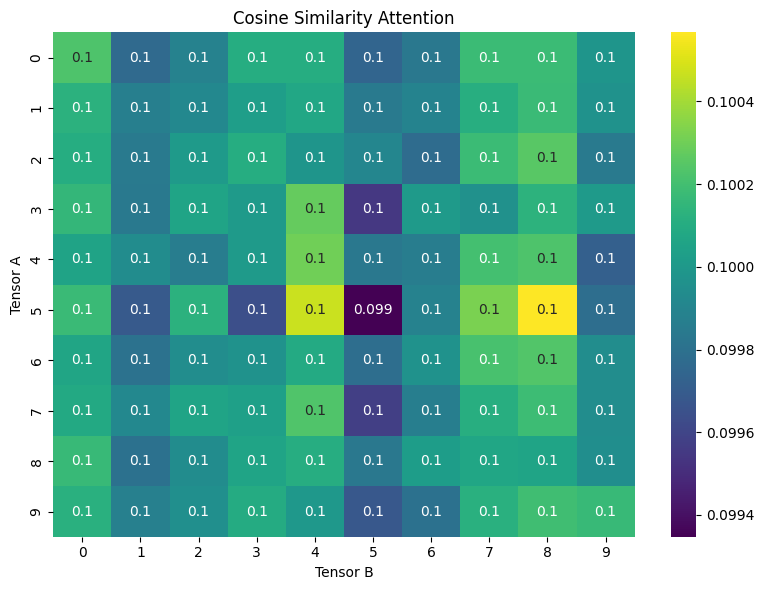

In [53]:
plot_attention_map(attn_matrix, title="Cosine Similarity Attention", annot=True)

# Code Bert Test

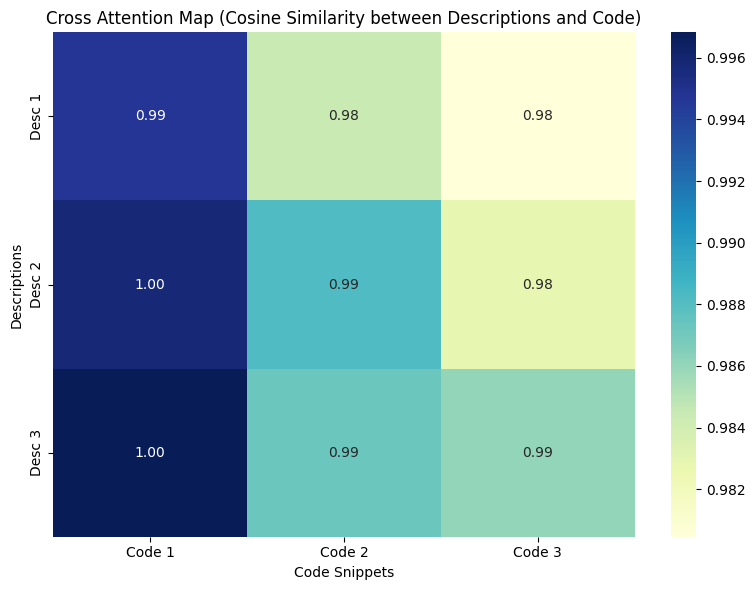

In [ ]:
from transformers import RobertaTokenizer, RobertaModel
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt
import seaborn as sns

model_path = "/media/ANONYMOUS/4TB_1/LLM_models/microsoft/codebert-base"

# Load model
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaModel.from_pretrained(model_path)
model.eval()

# Example input
descriptions = [
    "Sort a list of numbers in ascending order",
    "Open a file and write text to it",
    "Calculate the factorial of a number"
]

code_snippets = [
    "numbers.sort()",
    "with open('file.txt', 'w') as f:\n    f.write('hello')",
    "def factorial(n): return 1 if n==0 else n*factorial(n-1)"
]

# Function to get CLS embeddings
def get_cls_embeddings(text_list):
    with torch.no_grad():
        inputs = tokenizer(text_list, padding=True, truncation=True, return_tensors='pt')
        outputs = model(**inputs)
        cls_embeddings = outputs.last_hidden_state[:, 0, :]  # (batch_size, hidden_dim)
        return F.normalize(cls_embeddings, dim=1)

# Get embeddings
desc_embeds = get_cls_embeddings(descriptions)
code_embeds = get_cls_embeddings(code_snippets)

# Compute pairwise cosine similarity matrix (desc_count x code_count)
similarity_matrix = torch.matmul(desc_embeds, code_embeds.T)

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(similarity_matrix.cpu().numpy(),
            xticklabels=[f"Code {i+1}" for i in range(len(code_snippets))],
            yticklabels=[f"Desc {i+1}" for i in range(len(descriptions))],
            cmap='YlGnBu', annot=True, fmt=".2f")

plt.title("Cross Attention Map (Cosine Similarity between Descriptions and Code)")
plt.xlabel("Code Snippets")
plt.ylabel("Descriptions")
plt.tight_layout()
plt.show()


# Test with sentence_transformer

In [ ]:
from sentence_transformers import SentenceTransformer
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn.functional as F

# Load SBERT model
model = SentenceTransformer('/media/ANONYMOUS/4TB_1/LLM_models/all-MiniLM-L6-v2')

# Step 1: Encode descriptions and rules
desc_embeddings = model.encode(ctis, convert_to_tensor=True)  # [num_desc x dim]
rule_embeddings = model.encode(snorts, convert_to_tensor=True)        # [num_rules x dim]


In [44]:
desc_embeddings.shape

torch.Size([10, 384])

In [45]:
rule_embeddings.shape

torch.Size([10, 384])

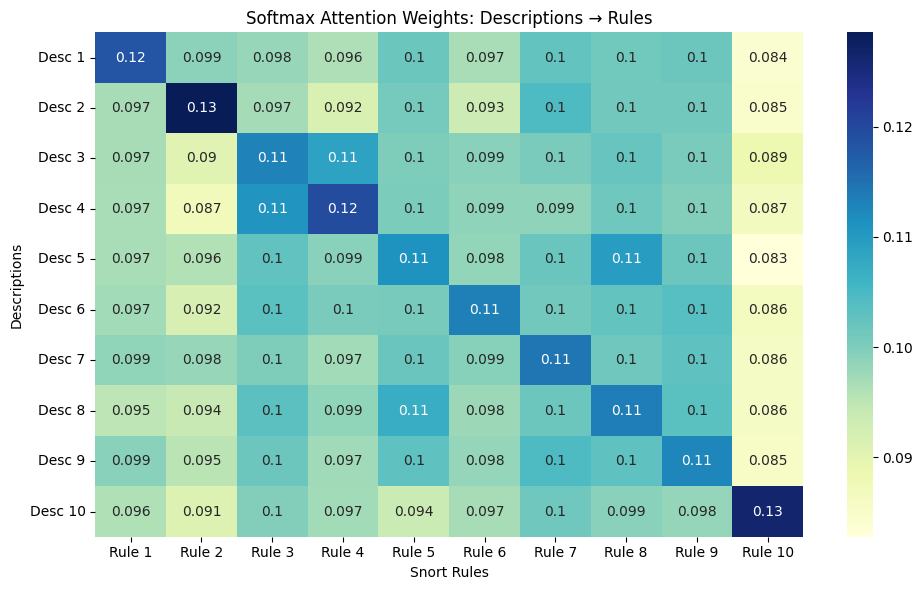

In [ ]:
# Step 2: Compute dot product matrix [num_desc x num_rules]
dot_product_matrix = torch.matmul(desc_embeddings, rule_embeddings.T)

# Step 3: Apply softmax along rules axis (dim=1), to get attention weights from each description to all rules
attention_weights = F.softmax(dot_product_matrix, dim=1).cpu().numpy()

